In [16]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.waveform_modes import get_td_waveform_modes
import gwnr
from pycbc.waveform import waveform_modes

import gwnr.waveform.enigma_utils as eu
import pycbc.conversions as convert
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#
from matplotlib.colors import ListedColormap

import matplotlib as mpl

 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt

In [17]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

In [18]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tshift_H+modified_20hyb_Feb16.txt',"r") 

lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e*q + A[6]*(e**2)*q + A[7]*(e)*math.cos(l + A[8]) + A[9]*(e**1)*(q**1)*math.cos(e*l + A[10]) + A[11]*(e**2)*math.cos(l + A[12])

g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tamp_H+modified_20hyb_Feb16.txt',"r") 

lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e*eta + B[6]*(e**2)*eta + B[7]*e*math.cos(l + B[8]) + B[9]*(e**1)*(eta**1)*math.cos(l + B[10]) + B[11]*(e**2)*math.cos(e*l + B[12])

g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tfreq_H+modified_20hyb_Feb16.txt',"r") 

lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e*eta + C[6]*(e**2)*eta + C[7]*e*eta*math.cos(l + C[8]) + C[9]*(e)*math.cos(l + C[10]) + C[11]*(e**2)*math.cos(e*l + C[12])

In [19]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

In [20]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


In [21]:
def enigma_gen(M,q,e0,l0,fref,delta_t):
    
    mass_1 = convert.mass1_from_mtotal_q(M,q)
    mass_2 = convert.mass2_from_mtotal_q(M,q)
    dL = 1
    s1z = s2z = 0
    mode2polfac=4*(5/(64*np.pi))**(1/2)
    iota = 0
    modes_to_use = [(2,2),(2,-2)]
    sample_rate = 4096
    distance = 1
    hp_en, hc_en = eu.get_imr_enigma_waveform(mass_1, mass_2, fref, sample_rate, s1z, s2z, e0, l0, iota, 0, 
                                          distance,
                                          modes_to_use=modes_to_use)
    
    time_en = hp_en.sample_times 
    
    #hp_en_new = hp_en / (G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
    #hc_en_new = hc_en / (G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
    
    return hp_en*mode2polfac, hc_en*mode2polfac, time_en

In [22]:
def esigma_stackup():
    %run Model_22_Updated.ipynb
    m = 60
    
    delta_t = 1./4096
    angle = 0
    d = 1
    k=0
    M_SI=m*MSUN_SI
    D_SI=(10**(6))*PC_SI
    mode2polfac=4*(5/(64*np.pi))**(1/2)
    
    q0 = np.loadtxt("optimal_mass_ratio.txt")
    
    e0 = np.loadtxt("optimal_eccentricity.txt")
    
    l0 = np.loadtxt("optimal_mean_ano.txt")
    
    x0 = 0.030
    
    f0 = fconv(x0,m)
    
    match_vals = np.loadtxt("optimal_match_vals.txt")
    
    hp_en_dict = {}
    t_en_dict = {}
    hp_E_dict = {}
    t_E_dict = {}
    
    for i in tqdm(range(len(q0))):

        hp_en, _, t_en = enigma_gen(m, q0[i], e0[i], l0[i], f0, delta_t)
        hp_E, _, t_E = model_22(m, q0[i], e0[i], l0[i], f0, angle, d, delta_t)
        
        hp_en, hp_E = waveform.utils.coalign_waveforms(hp_en, hp_E, psd=None, low_frequency_cutoff=None, high_frequency_cutoff=None, resize=True)
        hp_en_dict['hp_en{}'.format(i)] = hp_en
        t_en_dict['t_en{}'.format(i)] = t_en
    
        
        hp_E_dict['hp_E{}'.format(i)] = hp_E
        t_E_dict['t_E{}'.format(i)] = t_E
        
        
        
    plt.subplots(25,1,figsize=(12,46))
    for i in tqdm(range(len(q0))):
        plt.subplot(25, 1, i+1)
        
        plt.rc('xtick', labelsize=14) 
        plt.rc('ytick', labelsize=14) 
        mpl.rcParams['xtick.major.size'] = 12
        mpl.rcParams['xtick.major.width'] = 1
        mpl.rcParams['xtick.minor.size'] = 8
        mpl.rcParams['xtick.minor.width'] = 1
        mpl.rcParams['ytick.major.size'] = 12
        mpl.rcParams['ytick.major.width'] = 1
        mpl.rcParams['ytick.minor.size'] = 8
        mpl.rcParams['ytick.minor.width'] = 1
        plt.locator_params(axis='y',nbins=3)
        plt.tick_params(axis='y',direction='in',right=True)
        plt.tick_params(axis='x',direction='in',top=True)
        
        #Adding a constant shift to both waveform (not aliging the merger to zero!)
        SHIFT = ((hp_en_dict['hp_en'+str(i)]).sample_times)[np.argmax(hp_en_dict['hp_en'+str(i)])]/(m*MTSUN_SI)
        
        plt.plot((hp_en_dict['hp_en'+str(i)]).sample_times/(m*MTSUN_SI)-SHIFT,hp_en_dict['hp_en'+str(i)]/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='peachpuff',linewidth=4,label='IMRESIGMA')
        plt.plot((hp_E_dict['hp_E'+str(i)]).sample_times/(m*MTSUN_SI)-SHIFT,hp_E_dict['hp_E'+str(i)]/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),label='Model',color='darkblue',linestyle='--',linewidth=2,alpha=0.6)
        plt.ylabel(r'$h_+$',fontsize=15)
        plt.xlim(-8500,200)
        plt.text(-3800, 0.12, 'q = '+str(round(q0[i],4)), color='black', fontsize=13)
        plt.text(-2800, 0.12, 'e = '+str(round(e0[i],4)), color='black', fontsize=13)
        plt.text(-2800,-0.15, 'match = '+str(round(100*match_vals[i],2))+'\%', color='black', fontsize=13)

        plt.xlabel(r'$t/M$',fontsize=15)
        
        colors = ['peachpuff', 'darkblue']
        boundaries = [-0.2, 0.2]
        cmap = ListedColormap(colors)

        #Plot colorbar with custom colors
        cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1)))
        cb.set_ticks([-0.5, 0.5])
        cb.set_ticklabels(['EN', 'Model'])
        
        #plt.legend(loc='best',frameon=False,fontsize=14)
        plt.tight_layout()
    
    
        

100%|███████████████████████████████████████████| 25/25 [00:08<00:00,  3.00it/s]


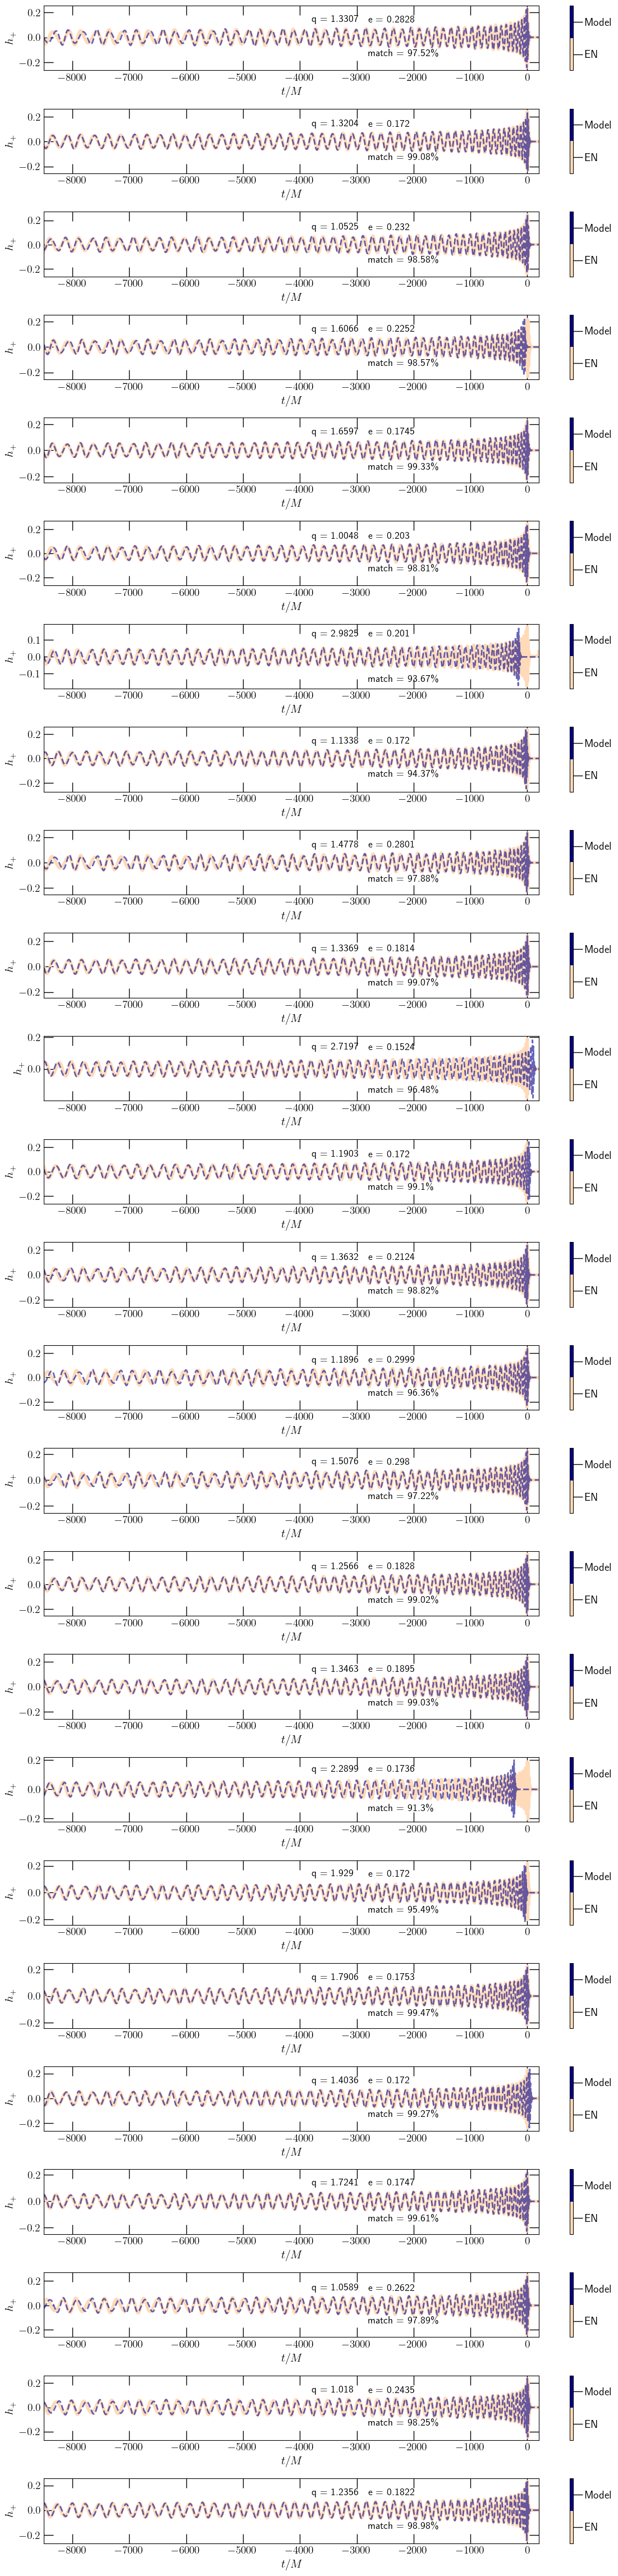

In [23]:
esigma_stackup()

## Optimizer

In [24]:
%run Model_22_Updated.ipynb
def MatchCalc(arr,verbose=False):
    M=60
    q = 2.98252
    e,l = arr
    delta_t = 1./4096
    match_val = []
    angle=0
    distance=1
    fmin = fconv(0.030,M)
    hp_model, hc_model,_ = model_22(M,q,e,l,fmin,angle,distance,delta_t)
    hp_enigma, hc_enigma, t_enigma = enigma_gen(M,q,e,l,fmin,delta_t)
    hp_en_TS = TimeSeries(hp_enigma,delta_t)
    tlen=max(len(hp_model),len(hp_en_TS))
    hp_model.resize(tlen)
    hp_en_TS.resize(tlen)
    delta_f = 1.0 / hp_model.duration
    flen = tlen//2 + 1
    f_low = 20
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    m, i = match(hp_model, hp_en_TS, psd=psd, low_frequency_cutoff=f_low)
    match_val.append(m)
    en_peak = hp_en_TS.sample_times[np.argmax(hp_en_TS)]; mod_peak = hp_model.sample_times[np.argmax(hp_model)]
    peak_diff = abs(en_peak-mod_peak)
    return (1-m)

In [25]:
import scipy.optimize as opt
bounds=[(0,0.4),(-np.pi,np.pi)]
res = opt.minimize(MatchCalc,x0=[0.201, 3.141592653589793],bounds=bounds, 
                   method='nelder-mead')
optimal = res.x

formatted_optimal = ", ".join("{:.15f}".format(val) for val in optimal)
print(f"Optimal : [{formatted_optimal}]")

#print(f"Optimal : {optimal:.15f}")
print(f"value : {res.fun}")

Optimal : [0.200960742187500, 3.141592653589793]
value : 0.06325888748912045


In [26]:
1-MatchCalc([0.200960742187500, 3.141592653589793])

0.9367411124513099